# import


In [1]:
"""
we make recommendation based on the similarity of the items for food recipes based on the ingredients and recipe specifications using the cosine similarity method 
and train word2vec model from scratch using gensim library on my dataset and then use the trained model to find the similarity between the ingredients of the recipes.
"""

# Importing the libraries
# !pip install textblob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Importing the dataset
df = pd.read_csv('recipes_data_graduation_project.csv')

# Data Preprocessing
df.head()

,name,url,category,author,summary,rating,rating_count,review_count,ingredients,directions,prep,cook,total,servings,yield,calories,carbohydrates_g,sugars_g,fat_g,saturated_fat_g,cholesterol_mg,protein_g,dietary_fiber_g,sodium_mg,calories_from_fat,calcium_mg,iron_mg,magnesium_mg,potassium_mg,vitamin_a_iu_IU,niacin_equivalents_mg,vitamin_c_mg,folate_mcg,thiamin_mg,diet_type,allergens,cuisine
0,Simple Macaroni and Cheese,https://www.allrecipes.com/recipe/238691/simpl...,main-dish,g0dluvsugly,A very quick and easy fix to a tasty side-dish...,4.42,834,575,1 (8 ounce) box elbow macaroni ; ¼ cup butter ...,Bring a large pot of lightly salted water to a...,10 mins,20 mins,30 mins,4,4 servings,630.2,55.0,7.6,33.6,20.9,99.6,26.5,2.1,777.0,302.2,567.9,2.7,61.8,380.0,1152.0,10.1,0.3,165.6,0.7,"vegetarian, omnivore, keto",milk,chinese
1,Gourmet Mushroom Risotto,https://www.allrecipes.com/recipe/85389/gourme...,main-dish,Myleen Sagrado Sjödin,Authentic Italian-style risotto cooked the slo...,4.80,3388,2245,"6 cups chicken broth, divided ; 3 tablespoons ...","In a saucepan, warm the broth over low heat. W...",20 mins,30 mins,50 mins,6,6 servings,430.6,56.6,4.4,16.6,6.6,29.3,11.3,2.7,1130.8,149.8,70.1,2.1,24.1,692.0,520.3,7.5,3.8,36.9,0.1,"vegetarian, omnivore, paleo, keto",milk,unknown
2,Dessert Crepes,https://www.allrecipes.com/recipe/19037/desser...,breakfast-and-brunch,ANN57,Essential crepe recipe. Sprinkle warm crepes ...,4.80,1156,794,"4 eggs, lightly beaten ; 1 ⅓ cups milk ; 2 ta...","In large bowl, whisk together eggs, milk, melt...",10 mins,10 mins,20 mins,8,8 crepes,163.8,17.2,5.3,7.7,3.4,111.1,6.4,0.4,234.5,69.0,65.6,1.2,11.2,115.4,347.8,2.3,0.1,43.5,0.2,"vegetarian, omnivore, paleo","eggs, milk",chinese
3,Pork Steaks,https://www.allrecipes.com/recipe/70463/pork-s...,meat-and-poultry,BABYLOVE1222,My mom came up with this recipe when I was a c...,4.57,689,539,¼ cup butter ; ¼ cup soy sauce ; 1 bunch green...,"Melt butter in a skillet, and mix in the soy s...",15 mins,30 mins,45 mins,6,6 servings,353.1,3.9,1.1,25.4,11.4,118.0,26.5,1.1,719.7,228.4,59.0,2.5,35.4,436.9,618.3,9.0,7.4,25.8,0.7,"omnivore, keto",milk,chinese
4,Quick and Easy Pizza Crust,https://www.allrecipes.com/recipe/20171/quick-...,bread,CHEF RIDER,This is a great recipe when you don't want to ...,4.70,3741,2794,1 (.25 ounce) package active dry yeast ; 1 tea...,Preheat oven to 450 degrees F (230 degrees C)....,_,_,_,8,1 12-inch pizza crust,169.8,28.1,0.6,4.0,0.6,NaN,4.8,1.1,292.8,36.3,7.3,1.8,10.5,55.4,0.8,4.1,NaN,89.1,0.3,paleo,wheat,chinese


In [2]:
df['rating'].loc[1]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35502 entries, 0 to 35501
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   35502 non-null  object 
 1   url                    35502 non-null  object 
 2   category               35502 non-null  object 
 3   author                 35502 non-null  object 
 4   summary                35502 non-null  object 
 5   rating                 35502 non-null  float64
 6   rating_count           35502 non-null  int64  
 7   review_count           35502 non-null  int64  
 8   ingredients            35502 non-null  object 
 9   directions             35502 non-null  object 
 10  prep                   35502 non-null  object 
 11  cook                   35502 non-null  object 
 12  total                  35502 non-null  object 
 13  servings               35502 non-null  int64  
 14  yield                  35501 non-null  object 
 15  ca

In [3]:

'''
data features:
['name', 'url', 'category', 'author', 'summary', 'rating',
       'rating_count', 'review_count', 'ingredients', 'directions', 'prep',
       'cook', 'total', 'servings', 'yield', 'calories', 'carbohydrates_g',
       'sugars_g', 'fat_g', 'saturated_fat_g', 'cholesterol_mg', 'protein_g',
       'dietary_fiber_g', 'sodium_mg', 'calories_from_fat', 'calcium_mg',
       'iron_mg', 'magnesium_mg', 'potassium_mg', 'vitamin_a_iu_IU',
       'niacin_equivalents_mg', 'vitamin_c_mg', 'folate_mcg', 'thiamin_mg',
       'diet_type', 'allergens', 'cuisine']
'''
df.columns

Index(['name', 'url', 'category', 'author', 'summary', 'rating',
       'rating_count', 'review_count', 'ingredients', 'directions', 'prep',
       'cook', 'total', 'servings', 'yield', 'calories', 'carbohydrates_g',
       'sugars_g', 'fat_g', 'saturated_fat_g', 'cholesterol_mg', 'protein_g',
       'dietary_fiber_g', 'sodium_mg', 'calories_from_fat', 'calcium_mg',
       'iron_mg', 'magnesium_mg', 'potassium_mg', 'vitamin_a_iu_IU',
       'niacin_equivalents_mg', 'vitamin_c_mg', 'folate_mcg', 'thiamin_mg',
       'diet_type', 'allergens', 'cuisine'],
      dtype='object')

In [4]:
# split features into text and numerical features 
text_features = ['name','category','summary','ingredients','diet_type','allergens','cuisine']

numerical_features = ['rating','total','servings','yield','calories','fat_g','protein_g','sugars_g','vitamin_c_mg','sodium_mg']


In [5]:
text_data = df[text_features]
numerical_data = df[numerical_features]

text_data.head()

,name,category,summary,ingredients,diet_type,allergens,cuisine
0,Simple Macaroni and Cheese,main-dish,A very quick and easy fix to a tasty side-dish...,1 (8 ounce) box elbow macaroni ; ¼ cup butter ...,"vegetarian, omnivore, keto",milk,chinese
1,Gourmet Mushroom Risotto,main-dish,Authentic Italian-style risotto cooked the slo...,"6 cups chicken broth, divided ; 3 tablespoons ...","vegetarian, omnivore, paleo, keto",milk,unknown
2,Dessert Crepes,breakfast-and-brunch,Essential crepe recipe. Sprinkle warm crepes ...,"4 eggs, lightly beaten ; 1 ⅓ cups milk ; 2 ta...","vegetarian, omnivore, paleo","eggs, milk",chinese
3,Pork Steaks,meat-and-poultry,My mom came up with this recipe when I was a c...,¼ cup butter ; ¼ cup soy sauce ; 1 bunch green...,"omnivore, keto",milk,chinese
4,Quick and Easy Pizza Crust,bread,This is a great recipe when you don't want to ...,1 (.25 ounce) package active dry yeast ; 1 tea...,paleo,wheat,chinese


# Recommendation for Text Data

In [6]:
text_data.head()


,name,category,summary,ingredients,diet_type,allergens,cuisine
0,Simple Macaroni and Cheese,main-dish,A very quick and easy fix to a tasty side-dish...,1 (8 ounce) box elbow macaroni ; ¼ cup butter ...,"vegetarian, omnivore, keto",milk,chinese
1,Gourmet Mushroom Risotto,main-dish,Authentic Italian-style risotto cooked the slo...,"6 cups chicken broth, divided ; 3 tablespoons ...","vegetarian, omnivore, paleo, keto",milk,unknown
2,Dessert Crepes,breakfast-and-brunch,Essential crepe recipe. Sprinkle warm crepes ...,"4 eggs, lightly beaten ; 1 ⅓ cups milk ; 2 ta...","vegetarian, omnivore, paleo","eggs, milk",chinese
3,Pork Steaks,meat-and-poultry,My mom came up with this recipe when I was a c...,¼ cup butter ; ¼ cup soy sauce ; 1 bunch green...,"omnivore, keto",milk,chinese
4,Quick and Easy Pizza Crust,bread,This is a great recipe when you don't want to ...,1 (.25 ounce) package active dry yeast ; 1 tea...,paleo,wheat,chinese


In [7]:
# preprocess text data old version
# # from tqdm import tqdm
# # import tqdm for notebook
# from tqdm.notebook import tqdm
# from textblob import TextBlob

# # tqdm.pandas(desc="progress-bar")

# # pbar = tqdm(total=len(text_data))

# # clean text data
# def clean_text(text):
#     # global pbar
#     # pbar = tqdm(total=len(text_data))

#     # remove backslash-apostrophe
#     text = re.sub("\'", "", text)
#     # remove everything except alphabets
#     text = re.sub("[^a-zA-Z]"," ",text)
#     # remove whitespaces
#     text = ' '.join(text.split())
#     # convert text to lowercase
#     text = text.lower()
#     # remove stopwords 
#     text = [word for word in text.split() if word not in stopwords.words('english')]
#     # lemmatize text in one line
#     text = " ".join([WordNetLemmatizer().lemmatize(word) for word in text])
#     # remove single characters
#     text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
#     # remove extra whitespace
#     text = re.sub(r'\s+', ' ', text, flags=re.I)

#     #convert plurals to singular e.g. tomatoes --> tomato using textblob library
#     from textblob import TextBlob

#     # text = " ".join([TextBlob(word).words.singularize() for word in text.split()])

#     words = TextBlob(text).words
#     singularized_words = [word.singularize() for word in words]
#     text = " ".join(str(word) for word in singularized_words)

#     pbar.update(1)

#     return text

# # create function to apply with progress bar 
# def apply_with_bar(column):
#     global pbar
    
#     pbar = tqdm(total=len(text_data))

#     text_data[f'{column}_cleaned'] = text_data[column].apply(clean_text)
#     print(f'Done cleaning {column}')
#     pbar.close()
    
# # apply function to all text columns
# clean_features = ['name','summary','ingredients'] # ,'summary','ingredients'
# for column in clean_features:
#     apply_with_bar(column)


In [ ]:
text_data.head()
# fill na in diet_type column with 'no_diet'
text_data['diet_type'].fillna('no_diet',inplace=True)
# fill na in allergens column with 'no_allergens'
text_data['allergens'].fillna('no_allergens',inplace=True)


In [ ]:
# print text cleaning steps
'''
 text cleaning steps 
    1- remove html tags
    2- remove special characters
    3- remove punctuation
    4- remove stopwords
    5- lemmatization
    6- lowercase
    7- remove numbers
    8- remove extra spaces
    9- remove single characters
    10- remove short words
    
'''
from tqdm.notebook import tqdm


# 1- remove html tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# 2- remove special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# 3- remove punctuation
def remove_punctuation(text):
    pattern = r'[^\w\s]'
    text = re.sub(pattern, '', text)
    return text

# 4- remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

# 5- lemmatization
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])
    return lemmatized_output

# 6- lowercase
def lowercase(text):
    return text.lower()

# 7- remove numbers
def remove_numbers(text):
    pattern = r'[0-9]'
    text = re.sub(pattern, '', text)
    return text

# 8- remove extra spaces
def remove_extra_spaces(text):
    pattern = r'\s+'
    text = re.sub(pattern, ' ', text)
    return text

# 9- remove single characters
def remove_single_characters(text):
    pattern = r'\s+[a-zA-Z]\s+'
    text = re.sub(pattern, ' ', text)
    return text

# 10- remove short words
def remove_short_words(text):
    pattern = r'\W*\b\w{1,3}\b'
    text = re.sub(pattern, '', text)
    return text

# 11 - conver plural to singular using textblob library
def singular(text):
    from textblob import TextBlob
    text = TextBlob(text)
    text = text.words.singularize()
    return text

# 12 - remove most 3 common words ['tablespoon','teaspoon','cup']
def remove_common_words(text):
    common_words = ['tablespoon','teaspoon','cup']
    text = ' '.join([word for word in text.split() if word not in common_words])
    return text
    

# apply all text cleaning steps
def text_cleaning(text):
    text = remove_html_tags(text)
    text = remove_special_characters(text)
    text = remove_punctuation(text)
    # print(text)
    text = remove_stopwords(text)
    text = lemmatization(text)
    text = lowercase(text)
    text = remove_numbers(text)
    text = remove_extra_spaces(text)
    text = remove_single_characters(text)
    # text = remove_short_words(text)
    # add text to string
    text = remove_common_words(text)
    text = singular(text)
    text = ' '.join(text)


    pbar.update(1)

    return text

# apply text cleaning steps on text data
# for feature in text_features:
#     text_data[feature] = text_data[feature].apply(text_cleaning)


# create function to apply with progress bar 
def apply_with_bar(org_data,column):
    global pbar
    
    pbar = tqdm(total=len(org_data))

    org_data[f'{column}_cleaned'] = org_data[column].apply(text_cleaning)
    print(f'Done cleaning {column}')
    pbar.close()
    
# apply function to all text columns
clean_features = ['summary']
clean_features = ['name','summary','ingredients']
clean_features = ['name', 'category', 'summary', 'ingredients','diet_type']
for column in clean_features:
    apply_with_bar(text_data,column)

In [12]:
apply_with_bar('diet_type')

  0%|          | 0/35502 [00:00<?, ?it/s]

Done cleaning diet_type


In [11]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35502 entries, 0 to 35501
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 35502 non-null  object
 1   category             35502 non-null  object
 2   summary              35502 non-null  object
 3   ingredients          35502 non-null  object
 4   diet_type            35502 non-null  object
 5   allergens            35502 non-null  object
 6   cuisine              35502 non-null  object
 7   name_cleaned         35502 non-null  object
 8   category_cleaned     35502 non-null  object
 9   summary_cleaned      35502 non-null  object
 10  ingredients_cleaned  35502 non-null  object
dtypes: object(11)
memory usage: 3.0+ MB


In [ ]:
# get most frequent words in ingredients column
from collections import Counter
Counter(" ".join(text_data["ingredients_cleaned"]).split()).most_common(100)


In [ ]:
text_data.head()

# show all text 
pd.set_option('display.max_colwidth', None)


In [ ]:
#counts_ingr = collections.Counter(total_ingredients)

counts_ingr = pd.Series(' '.join(text_data['ingredients_cleaned']).split()).value_counts()
counts_ingr.shape


(4961,)

In [ ]:
text_data.describe()

,name,category,summary,ingredients,diet_type,allergens,cuisine,name_cleaned,summary_cleaned,ingredients_cleaned,all_text,category_cleaned,diet_type_cleaned
count,35502,35502,35502,35502,35502,35502,35502,35502,35502,35502,35502,35502,35502
unique,35502,22,35477,35486,21,79,15,35387,35462,35461,35502,21,21
top,Simple Macaroni and Cheese,appetizers-and-snacks,Quick and easy.,12 eggs,"vegetarian, omnivore, keto",milk,chinese,strawberry shortcake,quick easy,egg,simple macaroni cheese ounce box elbow macaron...,appetizersandsnack,vegetarian omnivore keto
freq,1,5717,3,4,5377,10300,22606,3,6,7,1,5717,5377


In [ ]:
text_data['category'].value_counts()

appetizers-and-snacks              5717
desserts                           3959
side-dish                          3227
world-cuisine                      3117
main-dish                          2948
salad                              2809
bread                              2736
soups-stews-and-chili              2631
meat-and-poultry                   1909
trusted-brands-recipes-and-tips    1619
breakfast-and-brunch               1385
seafood                            1325
uncategorized                       751
everyday-cooking                    553
drinks                              415
fruits-and-vegetables               266
pasta-and-noodles                   116
holidays-and-events                  11
ingredients                           4
bbq-grilling                          2
515                                   1
251                                   1
Name: category, dtype: int64

In [13]:

# prepare data for word2vec model by merging all text columns into one column except allergens column split by '[sep]'
# text_data['all_text'] = text_data['name_cleaned'] + ' [sep] ' + text_data['category_cleaned'] + '[sep]' + text_data['summary_cleaned'] + '[sep]' + text_data['ingredients_cleaned'] + '[sep]' + text_data['diet_type'] + '[sep]' + text_data['cuisine']
# text_data['all_text'] = text_data['name_cleaned'] + ' ' + text_data['category_cleaned'] + ' ' + text_data['ingredients_cleaned'] + ' ' + text_data['diet_type'] + ' ' + text_data['cuisine']
text_data['all_text'] = text_data['name_cleaned'] + ' ' + text_data['ingredients_cleaned'] + ' ' + text_data['summary_cleaned'] + ' ' + text_data['diet_type_cleaned'] + ' ' + text_data['category_cleaned']
# + text_data['summary_cleaned'] + ' '

text_data.head()

,name,category,summary,ingredients,diet_type,allergens,cuisine,name_cleaned,category_cleaned,summary_cleaned,ingredients_cleaned,diet_type_cleaned,all_text
0,Simple Macaroni and Cheese,main-dish,A very quick and easy fix to a tasty side-dish...,1 (8 ounce) box elbow macaroni ; ¼ cup butter ...,"vegetarian, omnivore, keto",milk,chinese,simple macaroni cheese,maindish,a quick easy fix tasty sidedish fancy designer...,ounce box elbow macaroni butter allpurpose flm...,vegetarian omnivore keto,simple macaroni cheese ounce box elbow macaron...
1,Gourmet Mushroom Risotto,main-dish,Authentic Italian-style risotto cooked the slo...,"6 cups chicken broth, divided ; 3 tablespoons ...","vegetarian, omnivore, paleo, keto",milk,unknown,gourmet mushroom risotto,maindish,authentic italianstyle risotto cooked slow pai...,chicken broth divided olive oil divided pound ...,vegetarian omnivore paleo keto,gourmet mushroom risotto chicken broth divided...
2,Dessert Crepes,breakfast-and-brunch,Essential crepe recipe. Sprinkle warm crepes ...,"4 eggs, lightly beaten ; 1 ⅓ cups milk ; 2 ta...","vegetarian, omnivore, paleo","eggs, milk",chinese,dessert crepe,breakfastandbrunch,essential crepe recipe sprinkle warm crepe sug...,egg lightly beaten milk butter melted allpurpo...,vegetarian omnivore paleo,dessert crepe egg lightly beaten milk butter m...
3,Pork Steaks,meat-and-poultry,My mom came up with this recipe when I was a c...,¼ cup butter ; ¼ cup soy sauce ; 1 bunch green...,"omnivore, keto",milk,chinese,pork steak,meatandpoultry,my mom came recipe child it only way eat green...,butter soy sauce bunch green onion clove garli...,omnivore keto,pork steak butter soy sauce bunch green onion ...
4,Quick and Easy Pizza Crust,bread,This is a great recipe when you don't want to ...,1 (.25 ounce) package active dry yeast ; 1 tea...,paleo,wheat,chinese,quick easy pizza crust,bread,thi great recipe dont want wait dough rise you...,ounce package active dry yeast white sugar war...,paleo,quick easy pizza crust ounce package active dr...


In [14]:
corp = text_data['all_text'].astype(str).values.tolist()
corp[:3]
len(corp[0])

# get mean length of all text
mean_len = np.mean([len(x.split()) for x in corp])
mean_len

52.22959269900287

In [15]:
# tokenize the corpus
from nltk.tokenize import word_tokenize
corp_token = [word_tokenize(sent) for sent in corp]
# corp_token[:2]
# corp_token.append([""])

# corp_token[:10]

In [16]:
len(corp_token)

35502

In [17]:
# # build the word2vec model
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
# # word2vec_model = Word2Vec(sg = 1,workers=-1, min_count=1, window=13,size=225,min_alpha=0.0004906125939999643,iter=16,negative=15,alpha=0.005) # , min_count = 1, vector_size = 100, window = 5
# word2vec_model = Word2Vec(sg =1,workers=-1, min_count=1, vector_size = 50,epochs=500,window=15) # , min_count = 1, vector_size = 100, window = 5

# word2vec_model.build_vocab(corp_token) # , progress_per=2000
# word2vec_model.train(corp_token,total_examples=word2vec_model.corpus_count, epochs=500) #  epochs=50 , epochs=1000, compute_loss=True



In [18]:
#Train the Word2Vec model
from gensim.models import word2vec, phrases

num_features = 300    # Word vector dimensionality                      
min_word_count = 5 # 4                        
num_workers = 4 # 4      # Number of CPUs
context = 10          # Context window size; 

downsampling = 1e-2   # threshold for configuring which 
                      # higher-frequency words are randomly downsampled
                      #       

# Initialize and train the model 
word2vec_model = word2vec.Word2Vec(corp_token, workers=num_workers, 
            vector_size=num_features, min_count = min_word_count, 
            window = context,sample = downsampling, epochs=20)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

In [19]:
# merge all_text column into one string
all_text = ' '.join(text_data['all_text'].astype(str).values.tolist())

# tokenize the corpus
from nltk.tokenize import word_tokenize
all_text_token = word_tokenize(all_text)

# get word that appears less than 4 times
from collections import defaultdict
frequency = defaultdict(int)
for token in all_text_token:
    frequency[token] += 1

word_less_than_4 = [token for token in all_text_token if frequency[token] < 5]
'churn' in word_less_than_4

True

In [20]:
len(set(all_text_token))

22962

In [21]:
len(set(word_less_than_4))
len(set(all_text_token))

22962

In [22]:
word2vec_model.epochs

20

In [23]:
# word2vec_model.wv.most_similar(word,topn=5)

NameError: name 'word' is not defined

In [24]:
# get top 5 similar words to the list of words (shrimp , egg, mango, bread, rice) and get name result as dictionary
unique_words = ['shrimp','egg','mango','chicken','rice',"milk",'cheese']
similar_words = {}
for word in unique_words:
    # make unique words as key and top 5 similar words as value without score
    similar_words[word] = [item[0] for item in word2vec_model.wv.most_similar(word,topn=5)]
similar_words

{'shrimp': ['prawn', 'abalone', 'tail', 'crabmeat', 'lobster'],
 'egg': ['scalded', 'lightly', 'divided', 'needed', 'cornstarch'],
 'mango': ['papaya', 'cantaloupe', 'kiwi', 'jicama', 'nectarine'],
 'chicken': ['turkey', 'duck', 'beef', 'pheasant', 'veal'],
 'rice': ['distilled', 'mush', 'pistolette', 'steamed', 'quinoa'],
 'milk': ['water', 'buttermilk', 'unsweetened', 'flaked', 'unsalted'],
 'cheese': ['smy', 'halfandhalf', 'heavy', 'borden', 'devonshire']}

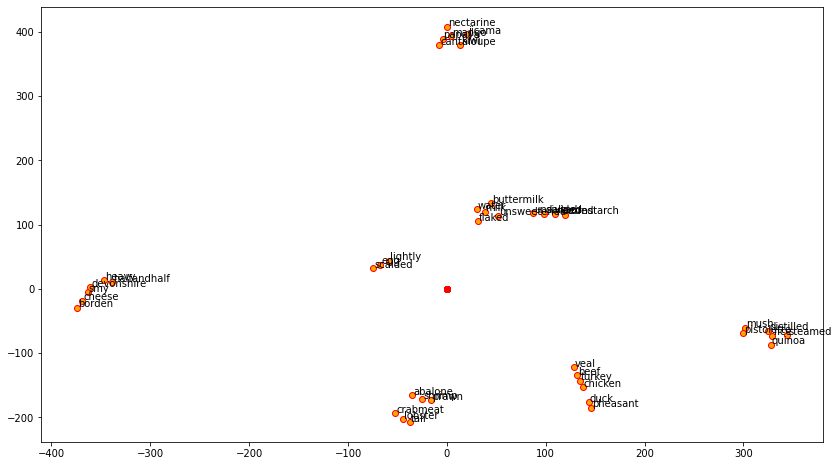

In [25]:
#visualization with Tsne
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = word2vec_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))

plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# make each key and it values with different color
import matplotlib.cm as cm
# set color to each key and its values
color = cm.rainbow(np.linspace(0, 1, len(similar_words.keys())))
for word, c in zip(similar_words.keys(), color):
    X = word2vec_model.wv[similar_words[word]]
    plt.scatter(X[:, 0], X[:, 1], c=[c])

plt.show()

In [26]:
# get word similarity
word2vec_model.wv.most_similar('chicken')
word2vec_model.wv.most_similar('chicken')

word2vec_model.wv.most_similar('cheese',topn=10)

[('smy', 0.4559411406517029),
 ('halfandhalf', 0.4019542634487152),
 ('heavy', 0.39922475814819336),
 ('borden', 0.3866536617279053),
 ('devonshire', 0.3864695429801941),
 ('sharp', 0.37129515409469604),
 ('chard', 0.3684406578540802),
 ('horn', 0.349124550819397),
 ('clotted', 0.33199745416641235),
 ('whipping', 0.3216049075126648)]

In [27]:
# check the loss of the model
word2vec_model.get_latest_training_loss()

# check the vocabulary size
word2vec_model.wv.index_to_key[:10]
len(word2vec_model.wv)

7013

In [28]:
# search for record that has  poth 'portokalopita' and 'cheese' in all_text column
text_data[text_data['all_text'].str.contains('pasta') & text_data['all_text'].str.contains('lox')]

# text_data[text_data['name_cleaned'].str.contains('comfort')]#['ingredients_cleaned'].values

,name,category,summary,ingredients,diet_type,allergens,cuisine,name_cleaned,category_cleaned,summary_cleaned,ingredients_cleaned,diet_type_cleaned,all_text


In [ ]:
# !pip install POT

In [ ]:
test_ingredient_1 = 'Simple Macaroni and Cheese'
test_ingredient_2 = 'box Macaroni and Cheese'
test_ingredient_3 = 'ounce box elbow macaroni cup butter cup allpurpose flmy teaspoon salt ground black pepper '
test_ingredient_4 = 'simple macaroni cheese'
# get similarity between two ingredients
word2vec_model.wv.n_similarity(test_ingredient_1.split(),test_ingredient_2.split())

# get similarity between two ingredients with different teqnique
word2vec_model.wv.wmdistance(test_ingredient_1.split(),test_ingredient_2.split())

# get similarity between two ingredients with different teqnique
# convert the ingredients to vector if the ingredients is in the vocabulary using get_vector_pre_trained function
# edit the function to split words
def get_vector_pre_trained(x,model):
    s_vec = w_vec = np.zeros(model.vector_size)
    
    for word in x.split():
        if word in model:
            w_vec = model[word]
            s_vec = s_vec + w_vec
    # if s_vec.all() == 0:
    #     s_vec = np.zeros(256)
    return s_vec

test_ingredient_1_vector = get_vector_pre_trained(test_ingredient_1,word2vec_model.wv)
test_ingredient_2_vector = get_vector_pre_trained(test_ingredient_2,word2vec_model.wv)
test_ingredient_3_vector = get_vector_pre_trained(test_ingredient_3,word2vec_model.wv)
test_ingredient_4_vector = get_vector_pre_trained(test_ingredient_4,word2vec_model.wv)


word2vec_model.wv.cosine_similarities(test_ingredient_1_vector,[test_ingredient_1_vector,test_ingredient_2_vector,text_data.loc[0,'name_vector'],test_ingredient_4_vector])

In [ ]:
'name', 'category', 'summary', 'ingredients'
clean_features = ['name', 'category', 'summary', 'ingredients','diet_type']

# get the unique values of each column


In [31]:
# create vector column for important columns 
text_data['ingredients_vector'] = text_data['ingredients_cleaned'].apply(lambda x: get_vector_pre_trained(x,word2vec_model.wv))
text_data['name_vector'] = text_data['name_cleaned'].apply(lambda x: get_vector_pre_trained(x,word2vec_model.wv))
text_data['category_vector'] = text_data['category_cleaned'].apply(lambda x: get_vector_pre_trained(x,word2vec_model.wv))
text_data['summary_vector'] = text_data['summary_cleaned'].apply(lambda x: get_vector_pre_trained(x,word2vec_model.wv))
text_data['diet_type_vector'] = text_data['diet_type_cleaned'].apply(lambda x: get_vector_pre_trained(x,word2vec_model.wv))

# convert to function


In [58]:
# get_vector_pre_trained('Simple Macaroni and Cheese',word2vec_model.wv)

# get similarity between two ingredients
# word2vec_model.wv.cosine_similarities(get_vector_pre_trained('Simple Macaroni and Cheese',word2vec_model.wv),get_vector_pre_trained('Simple Macaroni and Cheese',word2vec_model.wv))

In [ ]:
text_data.head()
# now we need to build a recommender system based on the ingredients, name, category, summary, diet_type to predict the best recipe for the user with high similarity
# we will use cosine similarity to get the similarity between the user input and the recipes in the dataset
# we will use the ingredients, name, category, summary, diet_type as features to predict the best recipe for the user

def get_similar_recipe(test_df_input):
    clean_features = ['name', 'category', 'summary', 'ingredients','diet_type']
    for column in clean_features:
        apply_with_bar(test_df_input,column)

    # get the vector of the input
    ingredients_vector = get_vector_pre_trained(test_df_input['ingredients_cleaned'][0],word2vec_model.wv)
    name_vector = get_vector_pre_trained(test_df_input['name_cleaned'][0],word2vec_model.wv)
    category_vector = get_vector_pre_trained(test_df_input['category_cleaned'][0],word2vec_model.wv)
    summary_vector = get_vector_pre_trained(test_df_input['summary_cleaned'][0],word2vec_model.wv)
    diet_type_vector = get_vector_pre_trained(test_df_input['diet_type_cleaned'][0],word2vec_model.wv)

    # get the cosine similarity between the input and the recipes in the dataset
    text_data['ingredients_similarity'] = text_data['ingredients_vector'].apply(lambda x: word2vec_model.wv.cosine_similarities(ingredients_vector,[x])[0])
    text_data['name_similarity'] = text_data['name_vector'].apply(lambda x: word2vec_model.wv.cosine_similarities(name_vector,[x])[0])
    text_data['category_similarity'] = text_data['category_vector'].apply(lambda x: word2vec_model.wv.cosine_similarities(category_vector,[x])[0])
    text_data['summary_similarity'] = text_data['summary_vector'].apply(lambda x: word2vec_model.wv.cosine_similarities(summary_vector,[x])[0])
    text_data['diet_type_similarity'] = text_data['diet_type_vector'].apply(lambda x: word2vec_model.wv.cosine_similarities(diet_type_vector,[x])[0])
    # get the mean of the similarity between the input and the recipes in the dataset
    text_data['mean_similarity'] = (text_data['ingredients_similarity'] + text_data['name_similarity'] + text_data['category_similarity'] + text_data['summary_similarity'] + text_data['diet_type_similarity'])/5
    # get the top 5 recipes with high similarity
    top_5_recipes = text_data.sort_values(by='mean_similarity',ascending=False).head(5)
    return top_5_recipes

# test the function
test_name = 'Macaroni and Cheese'
test_category = 'main-dish'
test_summary = 'This is a recipe for macaroni and cheese.'
test_ingredients = 'macaroni, cheese, butter, milk'
test_diet_type = 'Vegetarian'

# add to dataframe

test_df = pd.DataFrame({'name':[test_name],'category':[test_category],'summary':[test_summary],'ingredients':[test_ingredients],'diet_type':[test_diet_type]})
test_df

# clean_features = ['name', 'category', 'summary', 'ingredients','diet_type']
# for column in clean_features:
#     apply_with_bar(test_df,column)
# test_df
get_similar_recipe(test_df)

## word Net

In [ ]:
#visualize the ingredients in WordCloud 

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# create a list of ingredients
ingredients = []
for i in text_data['all_text']:
    # print(i)
    # break
    for j in i.split(' '):
        # print(i)
        # break

        ingredients.append(j)

ingredients[:10]

['simple',
 'macaroni',
 'cheese',
 'ounce',
 'box',
 'elbow',
 'macaroni',
 'cup',
 'butter',
 'cup']

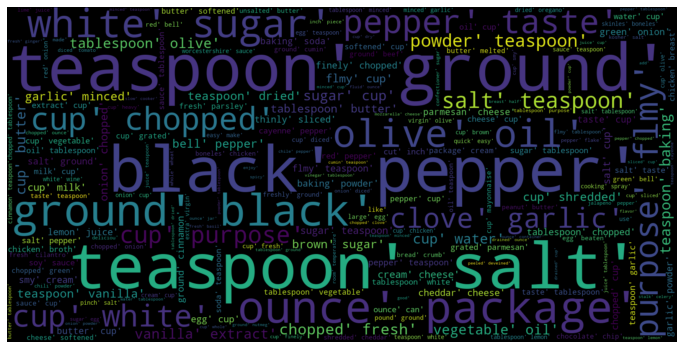

In [ ]:
#visualize the ingredients in WordCloud 

# create a word cloud of the ingredients
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(str(ingredients))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [ ]:
# create word net with all candidates role

# create word net with all candidates role
word_net_df_title = pd.DataFrame(columns=['word','count'])
# clean_cand_role   clean_cand_skills
word_net_df_title['word'] =  text_data['all_text'].apply(lambda x: x.split(' ')) #set(candidates_data_soft_BERT['clean_cand_role'].values)#.apply(lambda x: x.split(' '))
word_net_df_title = word_net_df_title.explode('word')
word_net_df_title['count'] = 1
word_net_df_title = word_net_df_title.groupby('word').sum().reset_index()
word_net_df_title = word_net_df_title.sort_values(by='count',ascending=False)
word_net_df_title = word_net_df_title.reset_index(drop=True)
word_net_df_title.head(10)

# word_net_df_title.shape

,word,count
0,cup,100168
1,teaspoon,62178
2,tablespoon,50140
3,ounce,30060
4,chopped,28096
5,pepper,26238
6,salt,22891
7,ground,21523
8,taste,20264
9,cheese,18941


In [ ]:
# visualize BERT model words relation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm.notebook as tq

# get the top 1000 words
word_net_df = word_net_df_title.iloc[:1000]

# get the word vectors
word_vectors = []
# FOR with tqdm

for word in tq.tqdm(word_net_df['word']):
# for word in word_net_df['word']:
    # get the word vector from the model word2vec
    try:
        vector = word2vec_model.wv[word]
        word_vectors.append(vector)
    except:
        # if the word is not in the vocabulary, the model will raise an exception
        # so we will skip the word
        pass
    # word_vectors.append(encode(word))

# numpy_array =[t.numpy()[0] for t in word_vectors]
numpy_array =[t for t in word_vectors]





  0%|          | 0/1000 [00:00<?, ?it/s]

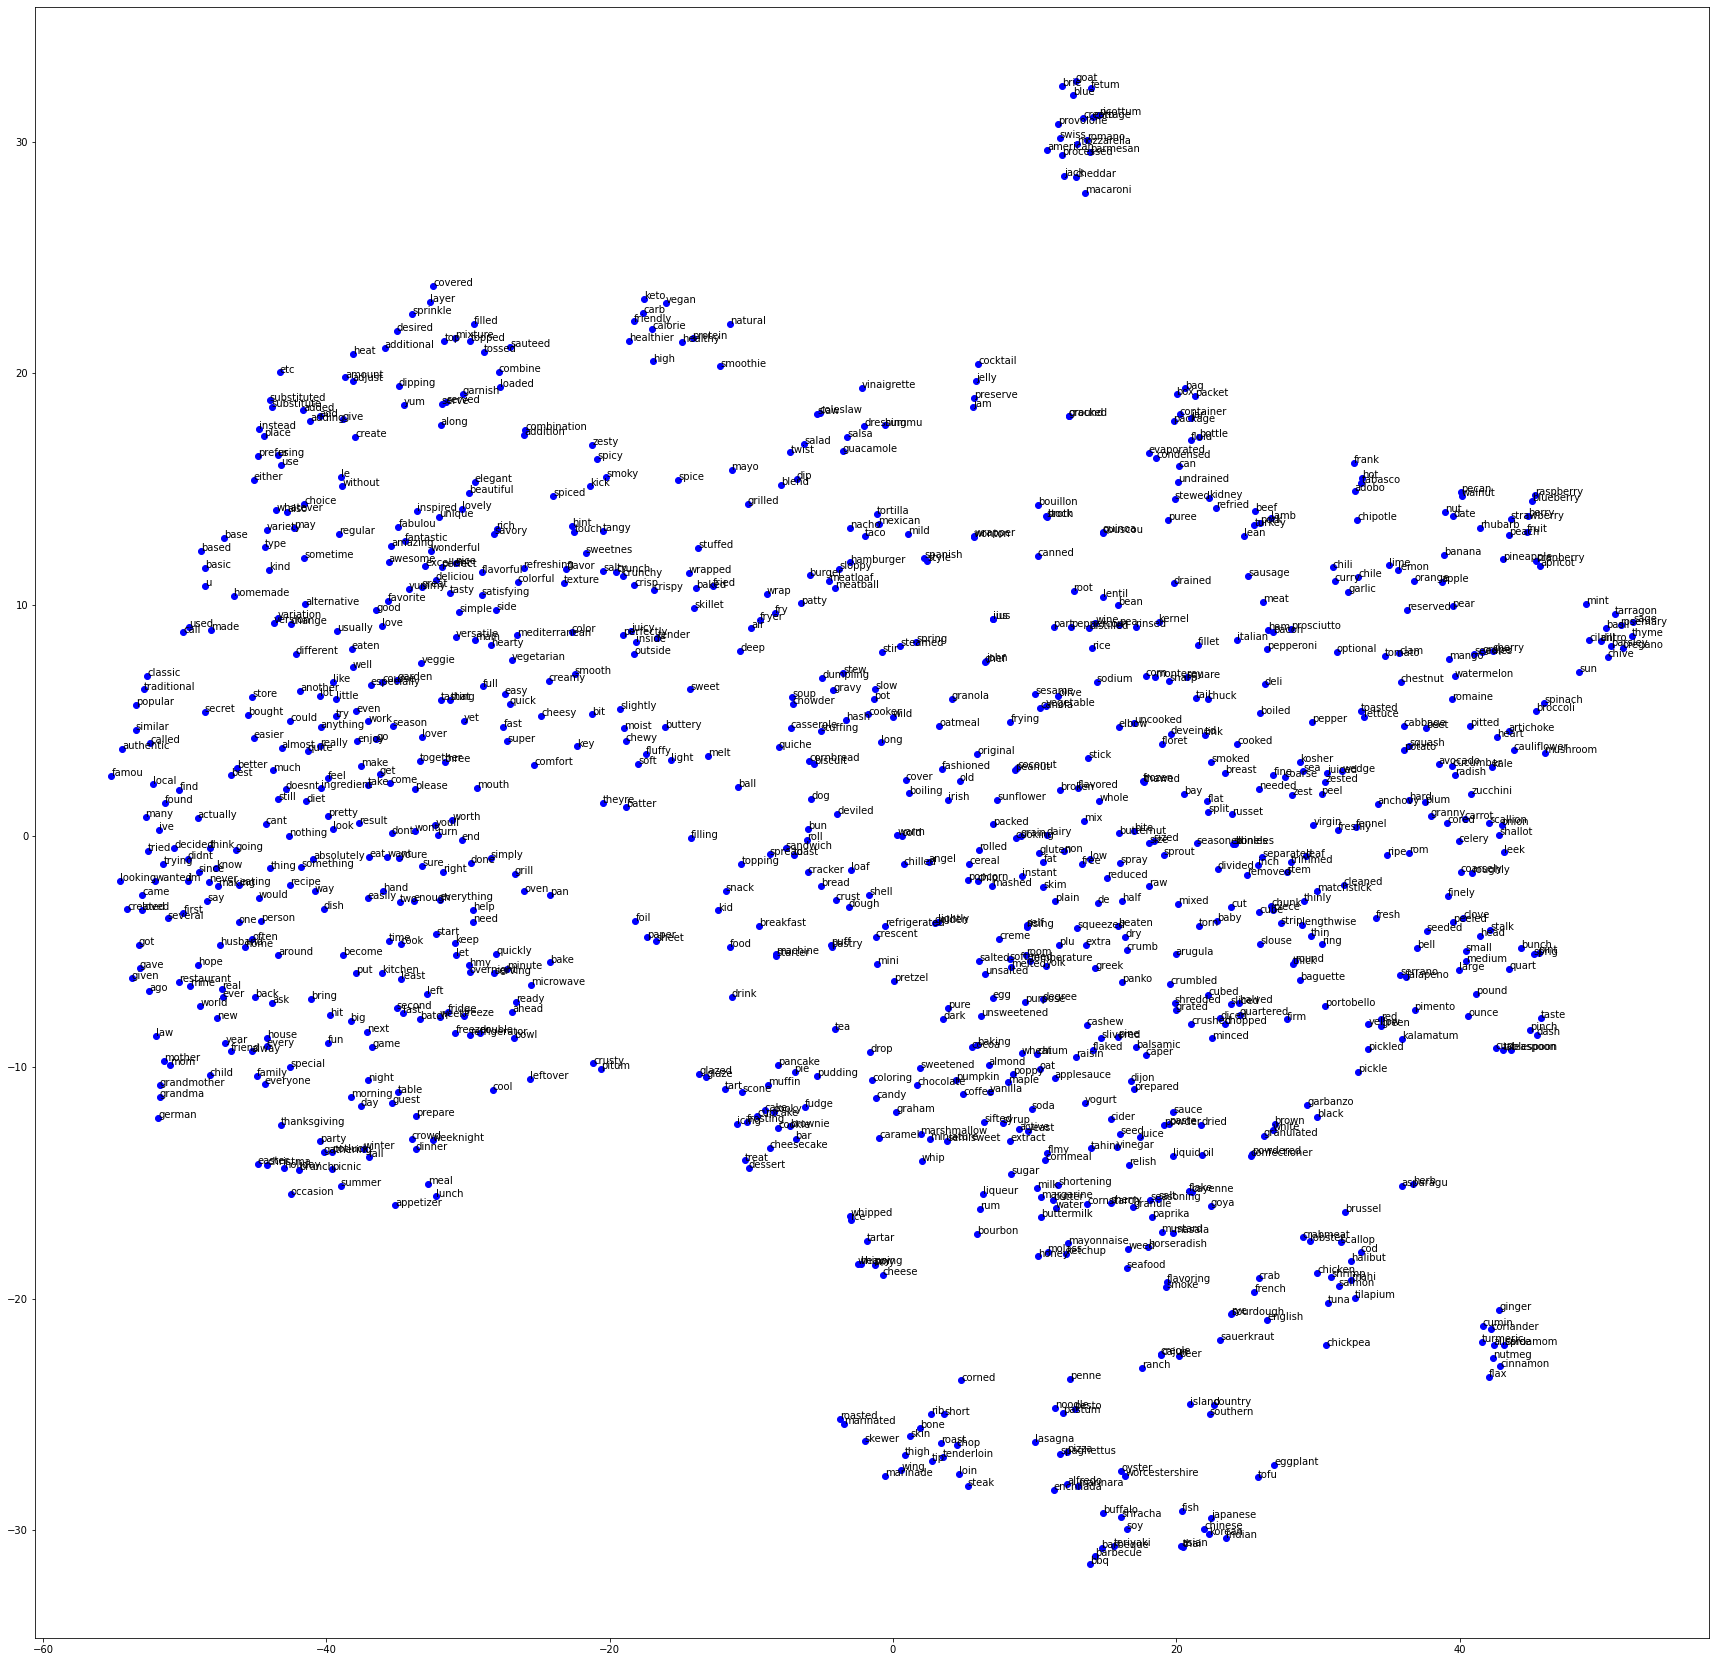

In [ ]:
# numpy_array =[t.numpy()[0] for t in word_vectors]
# numpy_array.reshape(-1, 1)
# reduce the dimensionality of the word vectors with pca for 50 dimensions and then with tsne for 2 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
word_vectors_50D = pca.fit_transform(np.array(numpy_array))

from sklearn.manifold import TSNE

# reduce the dimensionality of the word vectors with tsne for 2 dimensions


tsne = TSNE(n_components=2, random_state=0)

# get the 2D vectors
word_vectors_2D = tsne.fit_transform(word_vectors_50D)

# plot the 2D vectors
plt.figure(figsize=(30,30))
plt.scatter(word_vectors_2D[:,0], word_vectors_2D[:,1], c='blue')
for label, x, y in zip(word_net_df['word'], word_vectors_2D[:,0], word_vectors_2D[:,1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()



In [ ]:
text_data.head(2)

,name,category,summary,ingredients,diet_type,allergens,cuisine,name_cleaned,summary_cleaned,ingredients_cleaned,all_text
0,Simple Macaroni and Cheese,main-dish,A very quick and easy fix to a tasty side-dish...,1 (8 ounce) box elbow macaroni ; ¼ cup butter ...,"vegetarian, omnivore, keto",milk,chinese,simple macaroni cheese,quick easy fix tasty side dish fancy designer ...,ounce box elbow macaroni cup butter cup purpos...,simple macaroni cheese ounce box elbow macaron...
1,Gourmet Mushroom Risotto,main-dish,Authentic Italian-style risotto cooked the slo...,"6 cups chicken broth, divided ; 3 tablespoons ...","vegetarian, omnivore, paleo, keto",milk,unknown,gourmet mushroom risotto,authentic italian style risotto cooked slow pa...,cup chicken broth divided tablespoon olive oil...,gourmet mushroom risotto cup chicken broth div...


In [ ]:
# plot word net ingredients but color by category

# group by category
word_net_df_title_cat = pd.DataFrame(columns=['word','count','category'])
# clean_cand_role   clean_cand_skills
word_net_df_title_cat['word'] =  text_data['all_text'].apply(lambda x: x.split(' ')) #set(candidates_data_soft_BERT['clean_cand_role'].values)#.apply(lambda x: x.split(' '))
word_net_df_title_cat = word_net_df_title_cat.explode('word')
word_net_df_title_cat['count'] = 1
word_net_df_title_cat['category'] = text_data['category']
word_net_df_title_cat = word_net_df_title_cat.groupby(['word','category']).sum().reset_index()
word_net_df_title_cat = word_net_df_title_cat.sort_values(by='count',ascending=False)
word_net_df_title_cat = word_net_df_title_cat.reset_index(drop=True)
word_net_df_title_cat.head(10)

# drop the word that common in more than one category
# word_net_df_title_cat = word_net_df_title_cat.drop_duplicates(subset=['word'],keep=False)
word_net_df_title_cat.head(10)

# drop word if it on word_less_than_4
# word_net_df_title_cat = word_net_df_title_cat[~word_net_df_title_cat['word'].isin(word_less_than_4)]
word_net_df_title_cat.shape
# (4698, 3)


(72540, 3)

In [ ]:
# word2vec_model.wv['churn']
word_net_df_title_cat.iloc[:500].tail(10)

,word,category,count
490,soy,world-cuisine,601
491,pepper,uncategorized,600
492,brown,bread,600
493,use,appetizers-and-snacks,600
494,cut,main-dish,599
495,favorite,appetizers-and-snacks,598
496,oil,trusted-brands-recipes-and-tips,598
497,mushroom,appetizers-and-snacks,597
498,sliced,meat-and-poultry,597
499,ounce,breakfast-and-brunch,596


In [ ]:
# get the top 1000 words
word_net_df = word_net_df_title_cat.iloc[:500]

# get the word vectors
word_vectors = []
# FOR with tqdm

for word in tq.tqdm(word_net_df['word']):
# for word in word_net_df['word']:
    # get the word vector from the model word2vec
    try:
        vector = word2vec_model.wv[word]
        word_vectors.append(vector)
    except:
        # if the word is not in the vocabulary, the model will raise an exception
        # so we will skip the word
        print(word)
        pass
    # word_vectors.append(encode(word))

# numpy_array =[t.numpy()[0] for t in word_vectors]
numpy_array =[t for t in word_vectors]

numpy_array[:4]
len(numpy_array)


  0%|          | 0/500 [00:00<?, ?it/s]

500

In [ ]:
word_net_df['category'].astype('category').cat.codes.shape

(500,)

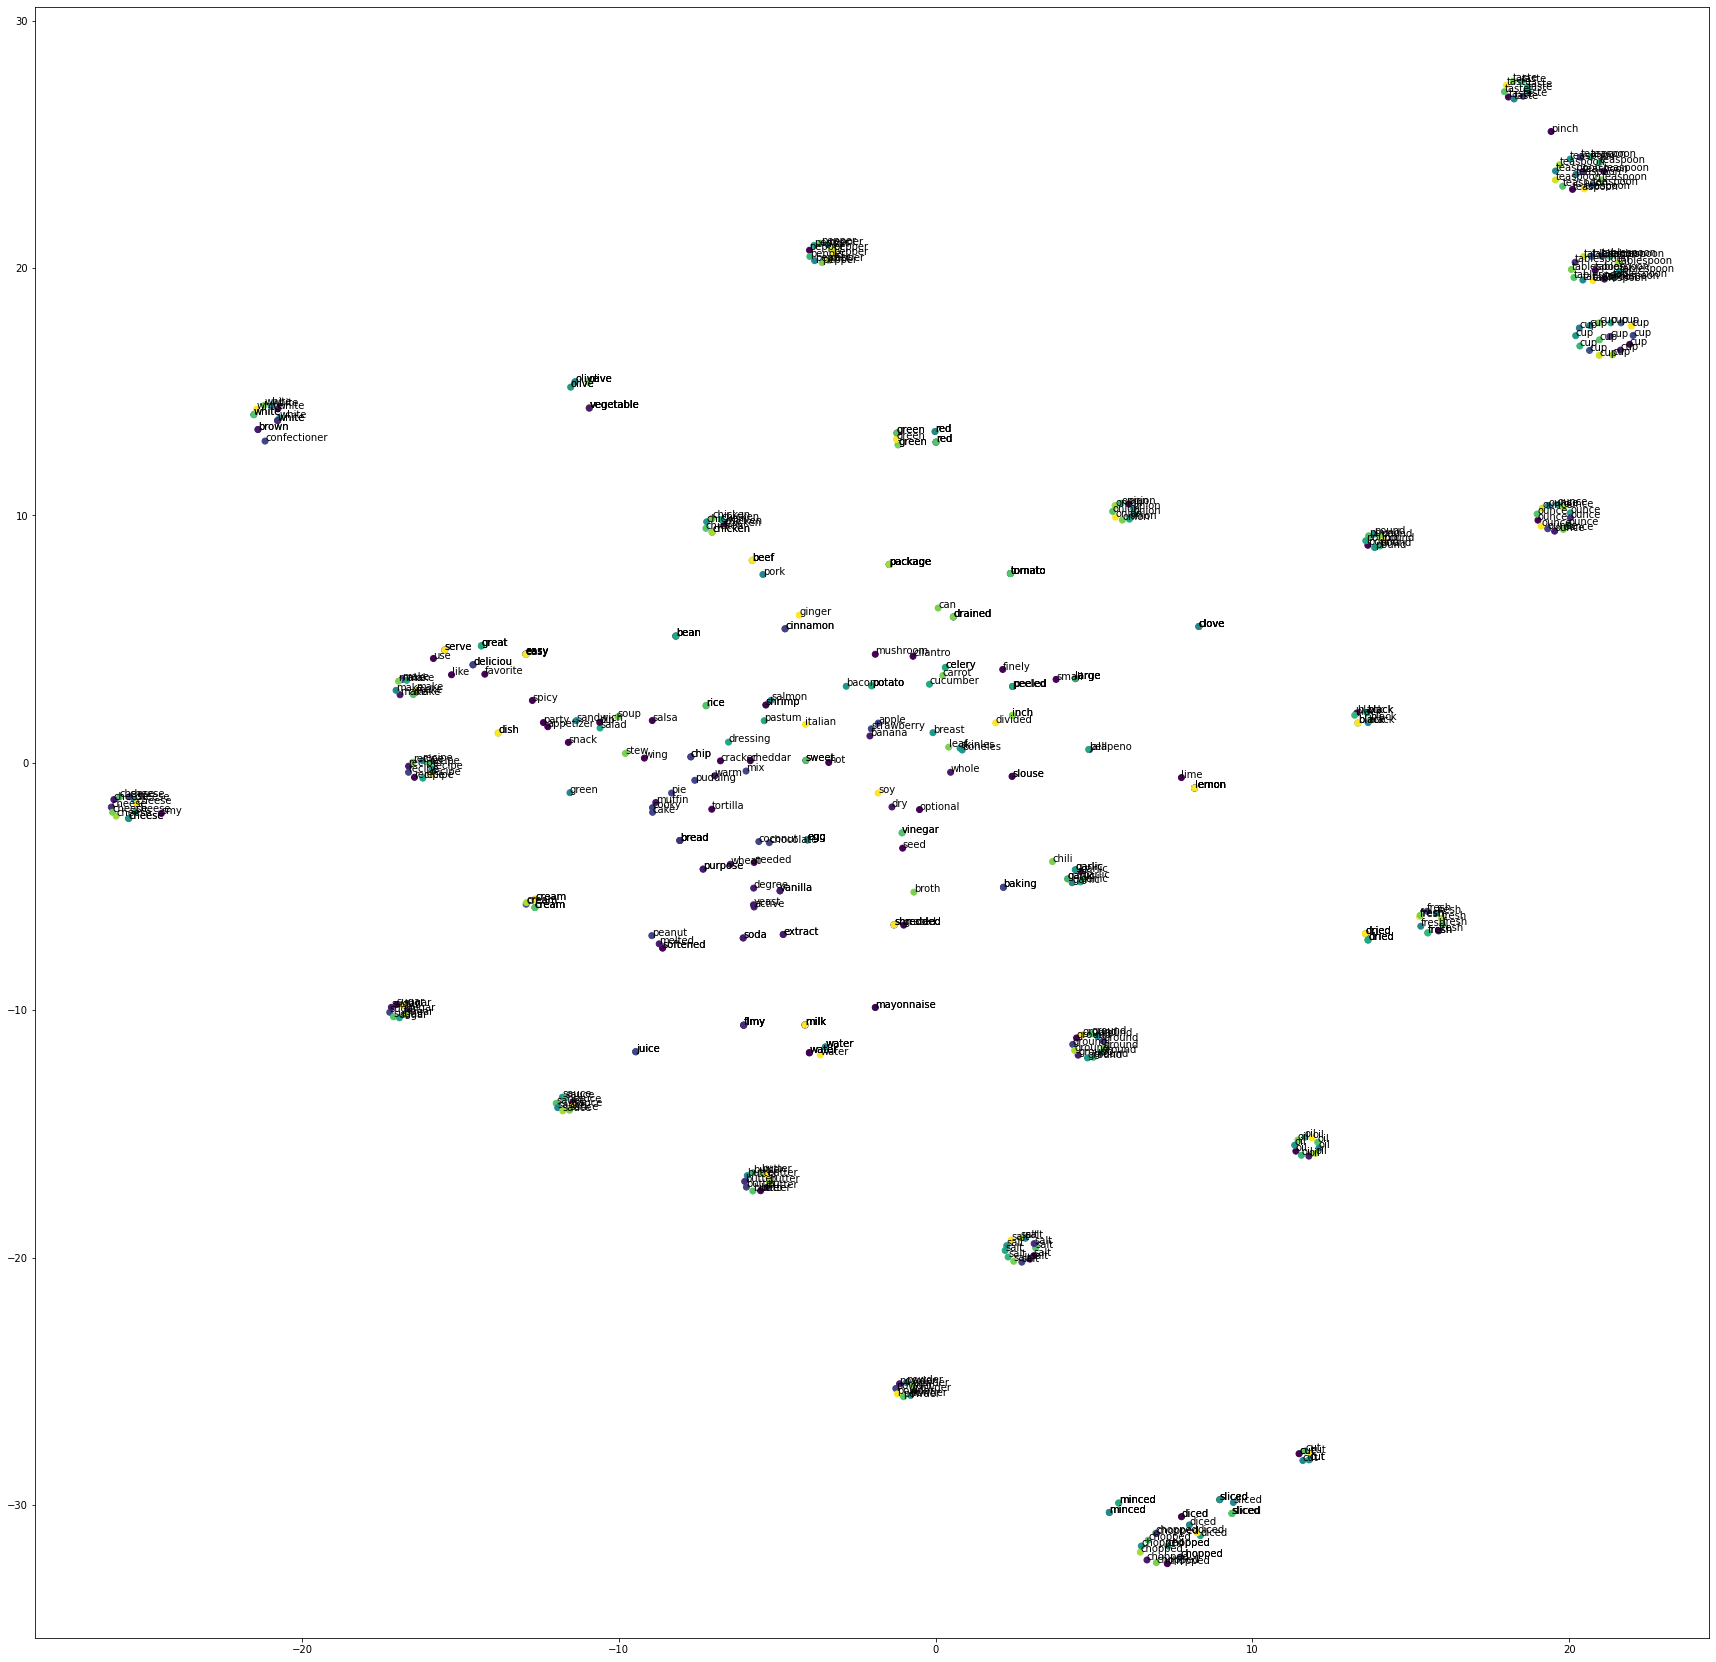

In [ ]:
# numpy_array =[t.numpy()[0] for t in word_vectors]
# numpy_array.reshape(-1, 1)

# reduce the dimensionality of the word vectors with pca for 50 dimensions and then with tsne for 2 dimensions and plot and color by category
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
word_vectors_50D = pca.fit_transform(np.array(numpy_array))

from sklearn.manifold import TSNE

# reduce the dimensionality of the word vectors with tsne for 2 dimensions


tsne = TSNE(n_components=2, random_state=0)

# get the 2D vectors
word_vectors_2D = tsne.fit_transform(word_vectors_50D)

# plot the 2D vectors
plt.figure(figsize=(30,30))
plt.scatter(word_vectors_2D[:,0], word_vectors_2D[:,1], c=word_net_df['category'].astype('category').cat.codes)
for label, x, y in zip(word_net_df['word'], word_vectors_2D[:,0], word_vectors_2D[:,1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

plt.show()

In [ ]:
text_data['category'].value_counts()

appetizers-and-snacks              5717
desserts                           3959
side-dish                          3227
world-cuisine                      3117
main-dish                          2948
salad                              2809
bread                              2736
soups-stews-and-chili              2631
meat-and-poultry                   1909
trusted-brands-recipes-and-tips    1619
breakfast-and-brunch               1385
seafood                            1325
uncategorized                       751
everyday-cooking                    553
drinks                              415
fruits-and-vegetables               266
pasta-and-noodles                   116
holidays-and-events                  11
ingredients                           4
bbq-grilling                          2
515                                   1
251                                   1
Name: category, dtype: int64

## edit word2vec function


In [ ]:
# w2v_model = 3
def user_or_job2vec_pre_trained(x,model):
    s_vec = w_vec = 0
    for word in x:
        if word in model:
            w_vec = model[word]
            s_vec = s_vec + w_vec
    return s_vec

# edit the function to split words
def get_vector_pre_trained(x,model):
    
    s_vec = w_vec = np.zeros(model.vector_size)
    
    for word in x.split():
        if word in model:
            w_vec = model[word]
            s_vec = s_vec + w_vec
    # if s_vec.all() == 0:
    #     s_vec = np.zeros(256)
    return s_vec

In [ ]:
def game ():
    while True:
        inp = int(input("enter 1 or 2"))
        if inp ==1:
            print(" you choose 1")
            break
        elif inp ==2:
            print(" you choose 2")
            break

        else:
            print(input("enter 1 or 2"))


    # while True:
    #     choice1 = input("(Please enter 1 or 2.)\n")
    #     if choice1 == "1":
    #         house(item, option)
    #         break
    #     elif choice1 == "2":
    #         cave(item, option)
    #         break
game()
        

 you choose 1
